# 基于backtrader的量化交易策略


### 基于backtrader的通用交易策略框架

* 使用这个通用策略的原因：

1. 不用去了解backtrader，简单易学。
2. 具备可迁移性，未来你用其他平台的交易工具，这里的代码很好迁移
3. 完全在交易程序外确定买卖方案，可以享受更丰富和高效的工具支持。如果在程序内部要进行数据分析，意味着需要把所有股票导入进去，由于backtrader自己特殊的数据结构，方便了交易的同时降低了数据分析的效率，因而常常导致面对大量股票运算速度被拖慢。
4. 程序外定买卖方案有一个缺点，就是没有办法利用组合投资的实时收益数据。这一点对于初学者或是要求不高的从业者，应当是可以接受的。

In [17]:
import sqlite3
import pandas as pd  
import talib
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
import numpy as np
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [18]:
# 读取全量数据
def read_hq():
    
    conn=sqlite3.connect(r'F:\BaiduNetdiskDownload\stock_2018_daily\stock_2018.db')
    #stock_daily=pd.read_sql("select * from stock_daily",con=conn)
    stock_daily=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ'",con=conn)

    stock_daily.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
           '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
           '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
           '总市值(万元)', '流通市值(万元)']
    stock_daily["date"]=stock_daily["date"].astype("str").astype("datetime64[ns]")
    stock_daily.set_index("date",inplace=True,drop=False)
    stock_daily["openinterest"]=0
    return stock_daily

#从全量数据中抽取个别股票数据
def get_data_1(syboml,time,stock_d):
    stock=stock_d[stock_d["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]
    stock=pd.concat([stock,time],axis=1).fillna(method="bfill").fillna(method="ffill")
    #stock=pd.concat([stock,time],axis=1).fillna(-1)#对每只股票缺失的交易日进行补齐
    return stock[["open","high","low","close","volume","openinterest"]]


#定义单个交易日中的策略
class my_strategy_date_2(bt.Strategy):
    #全局设定交易策略的参数
    cash_value={}
    params = (
        ("sell_d",{}),("buy_d",{})  # 注意要有逗号！！
    )

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    #单个交易日中的策略：先比较当天是否在买入或者卖出的日期中，如果在就获取日期对应的股票列表进行买卖操作
    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        self.cash_value.update({str(self.datetime.date(0)):self.broker.getvalue()})#记录持仓
        if str(self.datetime.date(0)) in self.params.sell_d.keys(): # 卖出目标股票
            s_list=self.params.sell_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
        if str(self.datetime.date(0)) in self.params.buy_d.keys(): # 买入目标股票
            s_list=self.params.buy_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

    # 下面两个函数log与notify_order都是为了在交易过程中输出交易记录和其他信息        
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

#读入策略并在所有交易日执行
def huice_run_num(start,end,buy_date,sell_date,stock_daily_x,stock_list,strategy):

    #实例化一个交易程序
    cerebro = bt.Cerebro()

    #把所有涉及到的股票数据塞入交易程序
    time_jy=pd.Series(range(0,len(stock_daily_x.date.unique())),index=stock_daily_x.date.unique()).sort_index()#构建包含所有交易日的序列
    for i in stock_list:#逐个输入涉及到的所有股票数据
        stock=get_data_1(i,time_jy,stock_daily_x)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)           
        cerebro.adddata(data,name=i) 
    
    #交易程序读入对应策略
    cerebro.addstrategy(strategy,sell_d=sell_date,buy_d=buy_date) 
    cerebro.broker.setcash(1000000) #定义初始金额
    cerebro.broker.setcommission(commission=0.002)#定义佣金


    #下面是数据交易完成后的相关评估参数
    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')#获得夏普率
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')#获得回撤
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return strategy.cash_value #这是累计收益数据，如果需要自己作图可以用这个
    #return cerebro

In [3]:
stock_daily=read_hq()

In [19]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()

In [20]:
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2020-09-23, 买入003002.SZ, 成交量38006，成交价13.02
2020-09-23, 买入003003.SZ, 成交量27075，成交价18.28
2023-02-03, 卖出003002.SZ, 成交量-38006，成交价20.89
2023-02-03, 卖出003003.SZ, 成交量-27075，成交价12.09
最终资金: 1127333.06
夏普比率: OrderedDict([('sharperatio', 0.13881751787754126)])
回撤指标: AutoOrderedDict([('len', 58), ('drawdown', 8.112109741974255), ('moneydown', 99523.99033479998), ('max', AutoOrderedDict([('len', 455), ('drawdown', 47.60672029972452), ('moneydown', 563812.145)]))])


<Axes: >

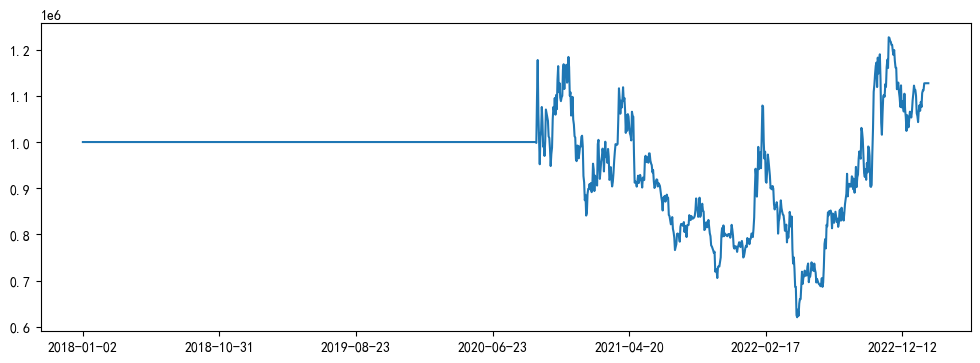

In [6]:
cash_value=pd.Series(result)
cash_value.plot(figsize=(12,4))

In [13]:
stock_name_id=stock_daily[["股票简称","股票代码"]].drop_duplicates().sort_values("股票代码")
#.to_csv("stock_name.csv",index=False)

In [16]:
stock_name_id=stock_name_id.set_index("股票简称")["股票代码"]

In [17]:
stock_name_id["比亚迪"]

'002594.SZ'

## 用沪深300作为对比基准

* ak.index_zh_a_hist 获取沪深300的指数历史数据的方法并作图

In [53]:
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="20180222", end_date="20230210")
index_zh_a_hist_df.set_index("日期",inplace=True)
print(index_zh_a_hist_df)

                 开盘       收盘       最高       最低        成交量           成交额    振幅  \
日期                                                                              
2018-02-22  4020.97  4052.73  4058.79  4009.92  105811571  1.383344e+11  1.23   
2018-02-23  4061.75  4071.09  4085.20  4035.23   99458747  1.281958e+11  1.23   
2018-02-26  4093.40  4118.42  4128.74  4048.98  137881001  1.790131e+11  1.96   
2018-02-27  4120.87  4058.98  4120.87  4051.81  125934469  1.696849e+11  1.68   
2018-02-28  4016.79  4023.64  4051.71  3991.71  109343593  1.524939e+11  1.48   
...             ...      ...      ...      ...        ...           ...   ...   
2023-02-06  4103.83  4086.88  4105.94  4065.22  110192717  2.263451e+11  0.98   
2023-02-07  4098.31  4094.23  4107.34  4077.96   91360072  1.835374e+11  0.72   
2023-02-08  4099.86  4076.14  4111.47  4072.65   84786099  1.705918e+11  0.95   
2023-02-09  4067.56  4130.86  4130.86  4064.75  102289961  2.117226e+11  1.62   
2023-02-10  4124.10  4106.31

In [54]:
index_time=index_zh_a_hist_df["收盘"][start.date().isoformat():end.date().isoformat()]

<Axes: xlabel='日期'>

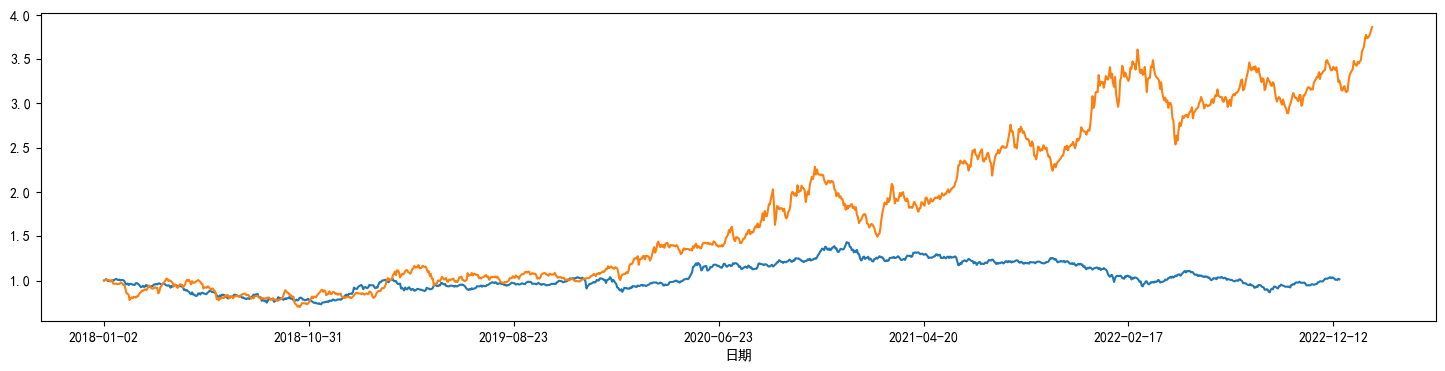

In [55]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

In [10]:
start.date().isoformat()

'2020-08-22'

## backtrader多股策略中交易机制的影响及其停牌涨停的处理

* 使用pandas编写策略，仅仅用backtrader作为交易结果分析器

* 默认下单模式

假设为日线数据，在next方法中调用订单方法。
执行逻辑为，当天收盘后提交订单，次日使用开盘价执行订单。

在backtrader中对任何时间粒度的数据，下单时机是当前bar（索引为0）的完成时间点；执行时机是下一根bar（索引为1）开始。

## 单因子策略

* 市值

市值，是指一家上市公司的发行股份按市场价格计算出来的股票总价值，其计算方法为每股股票的市场价格乘以发行总股数。整个股市上所有上市公司的市值总和，即为股票总市值。

以某个时间段为周期，基于市值因子排序选择特定股票买入和抛出

In [18]:
stock_daily.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest'],
      dtype='object')

In [24]:
str(time_i[i].date())

'2018-01-02'

In [21]:
stock_daily.date.sort_values().unique()

<DatetimeArray>
['2018-01-02 00:00:00', '2018-01-03 00:00:00', '2018-01-04 00:00:00',
 '2018-01-05 00:00:00', '2018-01-08 00:00:00', '2018-01-09 00:00:00',
 '2018-01-10 00:00:00', '2018-01-11 00:00:00', '2018-01-12 00:00:00',
 '2018-01-15 00:00:00',
 ...
 '2023-02-06 00:00:00', '2023-02-07 00:00:00', '2023-02-08 00:00:00',
 '2023-02-09 00:00:00', '2023-02-10 00:00:00', '2023-02-13 00:00:00',
 '2023-02-14 00:00:00', '2023-02-15 00:00:00', '2023-02-16 00:00:00',
 '2023-02-17 00:00:00']
Length: 1244, dtype: datetime64[ns]

In [41]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(0,len(time_i),30):
    stock_list_z=stock_daily[stock_daily.date==time_i[i]].sort_values("换手率(%)").head(top_num)["股票代码"].tolist()
    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [28]:
#buy_date

In [45]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300684.SZ, 成交量11741，成交价16.86
2018-01-03, 买入300735.SZ, 成交量11370，成交价17.41
2018-01-03, 买入300174.SZ, 成交量1648，成交价108.66
2018-01-03, 买入300042.SZ, 成交量2717，成交价66.31
2018-01-03, 买入300448.SZ, 成交量3279，成交价54.91
2018-02-14, 卖出300735.SZ, 成交量-11370，成交价18.47
2018-02-14, 卖出300042.SZ, 成交量-2717，成交价48.32
2018-02-14, 卖出300448.SZ, 成交量-3279，成交价44.49
2018-02-14, 卖出300684.SZ, 成交量-11741，成交价39.98
2018-02-14, 买入300110.SZ, 成交量4061，成交价48.27
2018-02-14, 买入300174.SZ, 成交量355，成交价109.11
2018-02-14, 买入300342.SZ, 成交量3981，成交价54.77
2018-02-14, 买入300301.SZ, 成交量7183，成交价30.53
2018-02-14, 买入300381.SZ, 成交量3444，成交价63.70
2018-04-04, 卖出300110.SZ, 成交量-4061，成交价32.95
2018-04-04, 卖出300381.SZ, 成交量-3444，成交价71.24
2018-04-04, 卖出300174.SZ, 成交量-2003，成交价104.42
2018-04-04, 卖出300342.SZ, 成交量-3981，成交价57.73
2018-04-04, 卖出300301.SZ, 成交量-7183，成交价32.26
2018-04-04, 买入300504.SZ, 成交量9283，成交价25.04
2018-04-04, 买入300116.SZ, 成交量3797，成交价50.04
2018-04-04, 买入300180.SZ, 成交量3592，成交价59.40
2018-04-04, 买入300108.S

<Axes: xlabel='日期'>

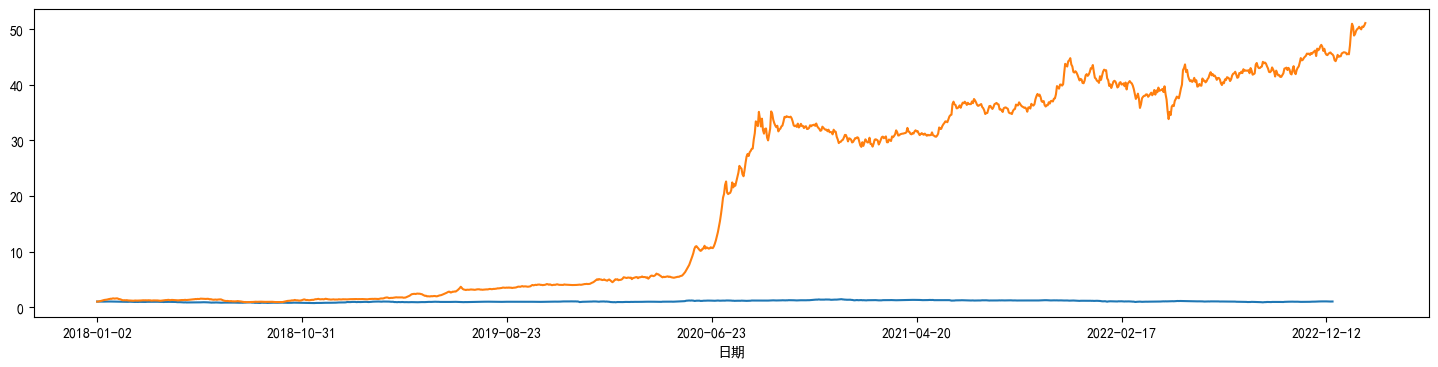

In [43]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

In [ ]:
    # stock_chi=stock_daily[(stock_daily["date"]==i)&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].tolist()
    # buy_list=stock_daily[(stock_daily["date"]==time0)&stock_daily["股票代码"].isin(stock_chi)].sort_values(by="总市值(万元)").head(top_n)["股票代码"].tolist()

In [73]:
time_index=pd.Series(stock_daily.date.unique()).sort_values().tolist()

In [18]:
#help(stock_daily.head)

## 换手率因子与规避涨停与停牌

In [51]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(0,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_list_z=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)].sort_values("换手率(%)").head(top_num)["股票代码"].tolist()
    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [52]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300174.SZ, 成交量1648，成交价108.66
2018-01-03, 买入300042.SZ, 成交量2717，成交价66.31
2018-01-03, 买入300448.SZ, 成交量3279，成交价54.91
2018-01-03, 买入300138.SZ, 成交量4029，成交价44.67
2018-01-03, 买入300178.SZ, 成交量2985，成交价60.47
2018-02-14, 卖出300178.SZ, 成交量-2985，成交价57.71
2018-02-14, 卖出300138.SZ, 成交量-4029，成交价38.11
2018-02-14, 卖出300042.SZ, 成交量-2717，成交价48.32
2018-02-14, 卖出300448.SZ, 成交量-3279，成交价44.49
2018-02-14, 卖出300174.SZ, 成交量-167，成交价109.11
2018-02-14, 买入300342.SZ, 成交量2942，成交价54.77
2018-02-14, 买入300301.SZ, 成交量5308，成交价30.53
2018-02-14, 买入300381.SZ, 成交量2545，成交价63.70
2018-02-14, 买入300187.SZ, 成交量1748，成交价91.65
2018-04-04, 卖出300381.SZ, 成交量-2545，成交价71.24
2018-04-04, 卖出300301.SZ, 成交量-5308，成交价32.26
2018-04-04, 卖出300174.SZ, 成交量-1481，成交价104.42
2018-04-04, 卖出300342.SZ, 成交量-2942，成交价57.73
2018-04-04, 买入300180.SZ, 成交量2757，成交价59.40
2018-04-04, 买入300108.SZ, 成交量3185，成交价51.64
2018-04-04, 买入300187.SZ, 成交量125，成交价86.55
2018-04-04, 买入300125.SZ, 成交量3152，成交价51.52
2018-04-04, 买入300132.SZ, 成交

## 回测与因子分析

## 多因子策略

* 市值，市盈率

In [53]:
stock_daily.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest'],
      dtype='object')

In [83]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(0,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)]
    z1=stock_oneday.loc[:,'市盈率(静态)'].rank(ascending=False)+stock_oneday.loc[:,'总市值(万元)'].rank()
    stock_list_z=pd.concat([stock_oneday["股票代码"],z1],axis=1).sort_values(0)["股票代码"].head(5).tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [81]:
pd.concat([stock_oneday["股票代码"],z1],axis=1).sort_values(0)["股票代码"].head(5).tolist()

['300354.SZ', '300211.SZ', '300126.SZ', '300442.SZ', '300093.SZ']

In [84]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300354.SZ, 成交量4436，成交价40.60
2018-01-03, 买入300211.SZ, 成交量4007，成交价45.04
2018-01-03, 买入300126.SZ, 成交量6771，成交价26.50
2018-01-03, 买入300442.SZ, 成交量8358，成交价21.67
2018-01-03, 买入300093.SZ, 成交量8713，成交价20.68
2018-02-14, 卖出300211.SZ, 成交量-4007，成交价38.53
2018-02-14, 卖出300442.SZ, 成交量-8358，成交价17.59
2018-02-14, 买入300354.SZ, 成交量188，成交价31.57
2018-02-14, 买入300220.SZ, 成交量3313，成交价43.67
2018-02-14, 买入300093.SZ, 成交量1333，成交价14.65
2018-02-14, 买入300404.SZ, 成交量5352，成交价27.23
2018-02-14, 卖出300126.SZ, 成交量-48，成交价21.53
2018-04-04, 卖出300220.SZ, 成交量-3313，成交价52.17
2018-04-04, 卖出300404.SZ, 成交量-5352，成交价44.38
2018-04-04, 卖出300354.SZ, 成交量-276，成交价44.34
2018-04-04, 买入300093.SZ, 成交量1197，成交价16.09
2018-04-04, 买入300092.SZ, 成交量9406，成交价19.34
2018-04-04, 买入300211.SZ, 成交量4272，成交价42.51
2018-04-04, 买入300126.SZ, 成交量753，成交价24.04
2018-05-22, 卖出300093.SZ, 成交量-11243，成交价15.87
2018-05-22, 买入300354.SZ, 成交量380，成交价37.70
2018-05-22, 买入300126.SZ, 成交量249，成交价22.84
2018-05-22, 买入300330.SZ, 成交量7863，成交价

In [52]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

NameError: name 'index_time' is not defined

In [42]:
stock_oneday.loc[:,"rank"]=stock_oneday['市盈率(静态)'].rank(ascending=False)+stock_oneday['总市值(万元)'].rank()

In [48]:
stock_oneday.sort_values("rank").head(5)["股票代码"].tolist()

['300354.SZ', '300211.SZ', '300126.SZ', '300442.SZ', '300093.SZ']

In [43]:
stock_oneday.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest', 'rank'],
      dtype='object')

In [32]:
stock_oneday["rank"]

date
2018-01-02     947.0
2018-01-02    1186.0
2018-01-02     926.0
2018-01-02     714.0
2018-01-02     938.0
               ...  
2018-01-02     350.0
2018-01-02     554.0
2018-01-02     401.0
2018-01-02     487.0
2018-01-02     862.0
Name: rank, Length: 650, dtype: float64

In [28]:
stock_oneday['总市值(万元)'].rank()

date
2018-01-02    590.0
2018-01-02    571.0
2018-01-02    640.0
2018-01-02    380.0
2018-01-02    361.0
              ...  
2018-01-02    196.0
2018-01-02    159.0
2018-01-02    291.0
2018-01-02    197.0
2018-01-02    419.0
Name: 总市值(万元), Length: 650, dtype: float64

In [57]:
df_0=pd.Series(range(0,len(s_0)),index=s_0)

300029.SZ      0
300106.SZ      1
300354.SZ      2
300028.SZ      3
300330.SZ      4
            ... 
300059.SZ    645
300072.SZ    646
300433.SZ    647
300676.SZ    648
300498.SZ    649
Length: 650, dtype: int64

In [63]:
(df_0+df_1).head(5).index.tolist()

['300029.SZ', '300106.SZ', '300354.SZ', '300028.SZ', '300330.SZ']

In [16]:
stock_daily_z["市盈率(静态)"].rank(ascending=False)

date
2018-01-02    357.0
2018-01-02    615.0
2018-01-02    286.0
2018-01-02    334.0
2018-01-02    577.0
              ...  
2018-01-02    154.0
2018-01-02    395.0
2018-01-02    110.0
2018-01-02    290.0
2018-01-02    443.0
Name: 市盈率(静态), Length: 650, dtype: float64

In [13]:
stock_daily_z["总市值(万元)"].rank()

date
2018-01-02    590.0
2018-01-02    571.0
2018-01-02    640.0
2018-01-02    380.0
2018-01-02    361.0
              ...  
2018-01-02    196.0
2018-01-02    159.0
2018-01-02    291.0
2018-01-02    197.0
2018-01-02    419.0
Name: 总市值(万元), Length: 650, dtype: float64

In [7]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(0,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_daily_z=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)]
    
    s_0=stock_daily_z.sort_values("总市值(万元)")["股票代码"].tolist()
    df_0=pd.Series(range(0,len(s_0)),index=s_0)
    s_1=stock_daily_z.sort_values("市盈率(静态)",ascending=False)["股票代码"].tolist()
    df_1=pd.Series(range(0,len(s_1)),index=s_1)
    stock_list_z=(df_0+df_1).sort_values().head(5).index.tolist()
    
    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [8]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300354.SZ, 成交量4436，成交价40.60
2018-01-03, 买入300211.SZ, 成交量4007，成交价45.04
2018-01-03, 买入300126.SZ, 成交量6771，成交价26.50
2018-01-03, 买入300442.SZ, 成交量8358，成交价21.67
2018-01-03, 买入300093.SZ, 成交量8713，成交价20.68
2018-02-14, 卖出300211.SZ, 成交量-4007，成交价38.53
2018-02-14, 卖出300442.SZ, 成交量-8358，成交价17.59
2018-02-14, 买入300354.SZ, 成交量188，成交价31.57
2018-02-14, 买入300220.SZ, 成交量3313，成交价43.67
2018-02-14, 买入300093.SZ, 成交量1333，成交价14.65
2018-02-14, 买入300404.SZ, 成交量5352，成交价27.23
2018-02-14, 卖出300126.SZ, 成交量-48，成交价21.53
2018-04-04, 卖出300220.SZ, 成交量-3313，成交价52.17
2018-04-04, 卖出300404.SZ, 成交量-5352，成交价44.38
2018-04-04, 卖出300354.SZ, 成交量-276，成交价44.34
2018-04-04, 买入300093.SZ, 成交量1197，成交价16.09
2018-04-04, 买入300092.SZ, 成交量9406，成交价19.34
2018-04-04, 买入300211.SZ, 成交量4272，成交价42.51
2018-04-04, 买入300126.SZ, 成交量753，成交价24.04
2018-05-22, 卖出300093.SZ, 成交量-11243，成交价15.87
2018-05-22, 买入300354.SZ, 成交量380，成交价37.70
2018-05-22, 买入300126.SZ, 成交量249，成交价22.84
2018-05-22, 买入300330.SZ, 成交量7863，成交价

<Axes: xlabel='日期'>

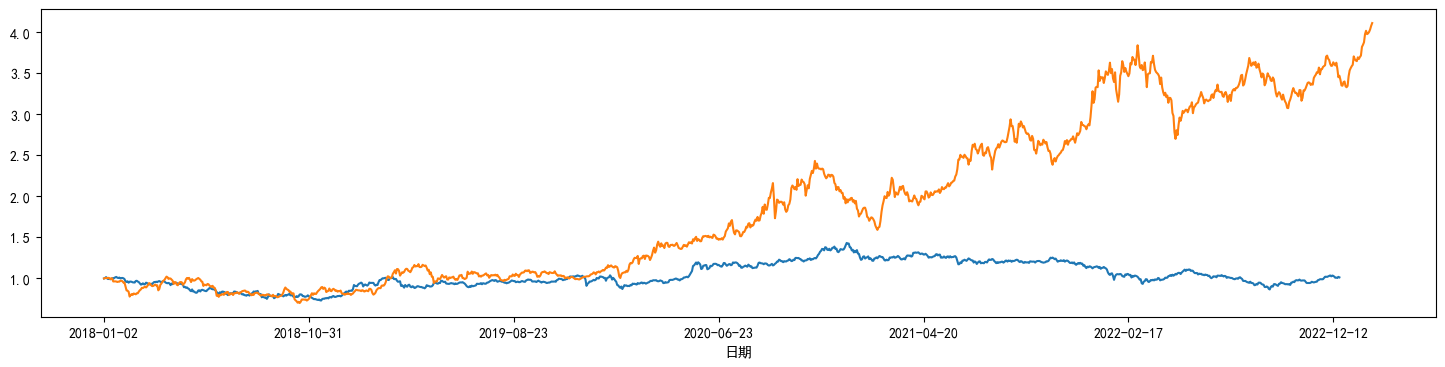

In [110]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

## 实现因子数量及其权重的任意定制

In [86]:
stock_columns={'总市值(万元)':[True,0.9],'市盈率(静态)':[False,1],'换手率(%)':[True,0.3]}

In [98]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(0,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)]
    z1=stock_oneday[s_list[0]].rank(ascending=stock_columns[s_list[0]][0])*stock_columns[s_list[0]][1]
    for j in s_list[1:]:
        z1=z1+stock_oneday[j].rank(ascending=stock_columns[j][0])*stock_columns[j][1]
    stock_list_z=pd.concat([stock_oneday["股票代码"],z1],axis=1).sort_values(0)["股票代码"].head(top_num).tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [99]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300211.SZ, 成交量4007，成交价45.04
2018-01-03, 买入300442.SZ, 成交量8358，成交价21.67
2018-01-03, 买入300354.SZ, 成交量4436，成交价40.60
2018-01-03, 买入300126.SZ, 成交量6771，成交价26.50
2018-01-03, 买入300093.SZ, 成交量8713，成交价20.68
2018-02-14, 卖出300093.SZ, 成交量-8713，成交价14.65
2018-02-14, 卖出300442.SZ, 成交量-48，成交价17.59
2018-02-14, 买入300354.SZ, 成交量188，成交价31.57
2018-02-14, 卖出300211.SZ, 成交量-204，成交价38.53
2018-02-14, 买入300220.SZ, 成交量3313，成交价43.67
2018-02-14, 卖出300126.SZ, 成交量-48，成交价21.53
2018-04-04, 卖出300220.SZ, 成交量-3313，成交价52.17
2018-04-04, 卖出300354.SZ, 成交量-4624，成交价44.34
2018-04-04, 卖出300442.SZ, 成交量-8310，成交价20.10
2018-04-04, 买入300126.SZ, 成交量255，成交价24.04
2018-04-04, 买入300092.SZ, 成交量8779，成交价19.34
2018-04-04, 买入300313.SZ, 成交量8083，成交价21.38
2018-04-04, 买入300211.SZ, 成交量184，成交价42.51
2018-04-04, 买入300483.SZ, 成交量4755，成交价35.46
2018-05-22, 卖出300313.SZ, 成交量-8083，成交价22.54
2018-05-22, 卖出300092.SZ, 成交量-8779，成交价20.01
2018-05-22, 卖出300483.SZ, 成交量-4755，成交价39.04
2018-05-22, 买入300330.SZ, 成交量7744，成交

In [90]:
s_list=list(stock_columns.keys())

In [91]:
stock_columns[s_list[0]][0]

True

In [94]:
z1=stock_oneday[s_list[0]].rank(ascending=stock_columns[s_list[0]][0])*stock_columns[s_list[0]][1]
for i in s_list[1:]:
    z1=z1+stock_oneday[i].rank(ascending=stock_columns[i][0])*stock_columns[i][1]

In [95]:
z1

date
2018-01-02     889.8
2018-01-02    1145.1
2018-01-02     895.0
2018-01-02     703.9
2018-01-02     958.0
               ...  
2018-01-02     525.4
2018-01-02     731.0
2018-01-02     548.0
2018-01-02     662.0
2018-01-02    1013.3
Length: 650, dtype: float64

<Axes: xlabel='日期'>

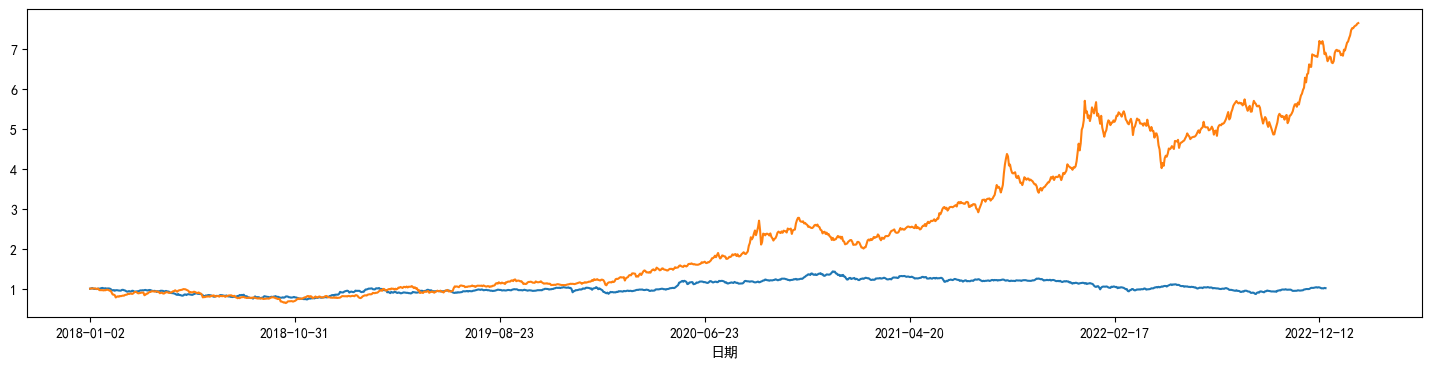

In [44]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()